# SVR Model Development

## Requirements

In [75]:
import os, sys
import joblib
from tempfile import mkdtemp

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import root_mean_squared_error
from skopt.space import Real, Categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

from sklearn.base import clone
from sklearn.svm import SVR

os.environ['JOBLIB_MULTIPROCESSING'] = '0'
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [44]:
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from model_evaluation import evaluate_model
from data_pipeline import MirrorLogNormScaler

## Data Setup

### Importing Data

In [3]:
df = pd.read_csv('../data/processed/rfe_dataset_2019_2025.csv', index_col='datetime')
print(df.shape)
df.head()

(52560, 30)


,price,temperature_24,temperature_28,temperature_33,temperature_40,temperature_46,relative_humidity_29,relative_humidity_36,relative_humidity_48,load_24,load_28,load_30,load_34,load_36,load_42,load_48,sum_cbet_24,sum_cbet_28,sum_cbet_32,sum_cbet_36,sum_cbet_43,sum_cbet_48,price_24,price_31,price_37,price_41,price_43,price_45,price_47,price_48
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03 00:00:00+00:00,45.22,3.600,4.450,5.775,6.200,6.875,72.50,77.25,87.25,41999.3,49667.4,52233.4,49527.7,48690.7,39151.5,40567.8,-12.315,-12.115,-13.875,-15.127,-14.598,-11.211,-45.92,0.07,0.12,-4.93,-17.25,-7.41,-4.08,10.07
2019-01-03 01:00:00+00:00,45.63,3.575,4.550,5.400,6.575,6.625,75.75,80.25,85.00,41813.9,47096.3,50141.2,53251.4,48874.6,41058.6,39550.0,-12.402,-12.443,-13.421,-15.877,-14.182,-11.405,-48.29,-4.97,-0.02,-6.33,-15.07,-12.55,-9.91,-4.08
2019-01-03 02:00:00+00:00,44.00,3.225,4.225,4.900,6.800,6.450,74.75,79.50,87.75,43015.6,44543.5,49667.4,54680.7,49527.7,43925.3,39140.7,-11.896,-11.299,-13.553,-15.827,-13.430,-12.343,-44.99,-6.98,0.00,-4.93,-4.93,-17.25,-7.41,-9.91
2019-01-03 03:00:00+00:00,43.88,3.150,3.925,4.900,6.750,6.450,77.25,77.00,90.50,45367.2,42768.9,47096.3,54425.7,53251.4,46800.1,38897.3,-12.147,-11.830,-13.425,-14.830,-13.808,-12.910,-48.93,-24.93,-0.03,0.45,-6.33,-15.07,-12.55,-7.41
2019-01-03 04:00:00+00:00,45.92,2.925,3.600,4.850,6.875,6.525,77.00,76.25,90.50,50485.4,41999.3,44543.5,52233.4,54680.7,48938.6,37879.9,-11.743,-12.315,-12.115,-13.875,-13.935,-13.946,-29.91,-4.87,1.97,0.12,-4.93,-4.93,-17.25,-12.55


In [4]:
datetime = pd.to_datetime(df.index, utc=True)
X = df.drop(columns='price')
y = df[['price']]

### Base Train-Test Split

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

print(f'---- Training & Validation Feature Matrix (X_train_val) ----\n{X_train_val.shape}')
display(X_train_val)

print(f'---- Test Feature Matrix (X_train_val) ----\n{X_test.shape}')
display(X_test)

print(f'---- Training & Validation Target Array (y_train_val) ----\n{y_train_val.shape}')
display(y_train_val)

print(f'---- Test Target Array (y_test) ----\n{y_test.shape}')
display(y_test)

---- Training & Validation Feature Matrix (X_train_val) ----
(47304, 29)


,temperature_24,temperature_28,temperature_33,temperature_40,temperature_46,relative_humidity_29,relative_humidity_36,relative_humidity_48,load_24,load_28,load_30,load_34,load_36,load_42,load_48,sum_cbet_24,sum_cbet_28,sum_cbet_32,sum_cbet_36,sum_cbet_43,sum_cbet_48,price_24,price_31,price_37,price_41,price_43,price_45,price_47,price_48
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03 00:00:00+00:00,3.600,4.450,5.775,6.200,6.875,72.50,77.25,87.25,41999.3,49667.4,52233.4,49527.7,48690.7,39151.5,40567.8,-12.315,-12.115,-13.875,-15.127,-14.598,-11.211,-45.92,0.07,0.12,-4.93,-17.25,-7.41,-4.08,10.07
2019-01-03 01:00:00+00:00,3.575,4.550,5.400,6.575,6.625,75.75,80.25,85.00,41813.9,47096.3,50141.2,53251.4,48874.6,41058.6,39550.0,-12.402,-12.443,-13.421,-15.877,-14.182,-11.405,-48.29,-4.97,-0.02,-6.33,-15.07,-12.55,-9.91,-4.08
2019-01-03 02:00:00+00:00,3.225,4.225,4.900,6.800,6.450,74.75,79.50,87.75,43015.6,44543.5,49667.4,54680.7,49527.7,43925.3,39140.7,-11.896,-11.299,-13.553,-15.827,-13.430,-12.343,-44.99,-6.98,0.00,-4.93,-4.93,-17.25,-7.41,-9.91
2019-01-03 03:00:00+00:00,3.150,3.925,4.900,6.750,6.450,77.25,77.00,90.50,45367.2,42768.9,47096.3,54425.7,53251.4,46800.1,38897.3,-12.147,-11.830,-13.425,-14.830,-13.808,-12.910,-48.93,-24.93,-0.03,0.45,-6.33,-15.07,-12.55,-7.41
2019-01-03 04:00:00+00:00,2.925,3.600,4.850,6.875,6.525,77.00,76.25,90.50,50485.4,41999.3,44543.5,52233.4,54680.7,48938.6,37879.9,-11.743,-12.315,-12.115,-13.875,-13.935,-13.946,-29.91,-4.87,1.97,0.12,-4.93,-4.93,-17.25,-12.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-26 19:00:00+00:00,15.925,20.175,17.775,13.000,14.175,60.25,81.00,81.50,40974.9,43653.1,42510.3,47756.8,46629.1,35233.1,46657.0,9.457,7.527,-1.346,5.417,8.544,5.399,136.95,0.00,78.58,89.03,90.43,94.88,109.67,115.84
2024-05-26 20:00:00+00:00,14.675,20.250,18.525,13.475,13.950,57.25,77.75,87.75,38033.7,43874.9,42203.1,46974.1,48055.2,35454.2,43444.1,9.442,9.778,-0.154,3.700,7.960,5.578,115.77,0.02,74.75,90.26,89.16,91.83,99.84,109.67
2024-05-26 21:00:00+00:00,14.225,18.950,19.300,13.850,13.825,60.25,72.50,88.75,37385.6,42941.7,43653.1,44795.8,47756.8,36553.7,39003.3,8.678,10.533,3.979,0.488,8.334,7.119,104.54,14.23,54.23,90.68,89.03,90.43,94.88,99.84


---- Test Feature Matrix (X_train_val) ----
(5256, 29)


,temperature_24,temperature_28,temperature_33,temperature_40,temperature_46,relative_humidity_29,relative_humidity_36,relative_humidity_48,load_24,load_28,load_30,load_34,load_36,load_42,load_48,sum_cbet_24,sum_cbet_28,sum_cbet_32,sum_cbet_36,sum_cbet_43,sum_cbet_48,price_24,price_31,price_37,price_41,price_43,price_45,price_47,price_48
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-05-27 00:00:00+00:00,13.600,14.675,20.175,15.975,13.175,82.75,61.25,91.50,33801.8,38033.7,41488.4,42203.1,43489.4,45104.8,35273.8,11.763,9.442,9.778,-0.154,7.309,8.544,90.77,115.77,0.04,74.75,86.23,90.26,89.16,90.43
2024-05-27 01:00:00+00:00,12.975,14.225,20.250,16.925,13.000,89.75,58.75,91.25,33965.5,37385.6,40974.9,43653.1,42510.3,46629.1,35233.1,12.092,8.678,10.533,3.979,6.470,7.960,90.10,131.92,0.00,54.23,78.58,90.68,89.03,89.16
2024-05-27 02:00:00+00:00,12.350,14.150,18.950,17.775,13.475,91.25,60.25,91.00,33969.5,35273.0,38033.7,43874.9,42203.1,48055.2,35454.2,13.098,9.937,10.927,5.972,5.417,8.334,91.16,136.95,0.02,9.34,74.75,86.23,90.26,89.03
2024-05-27 03:00:00+00:00,12.175,13.600,17.500,18.525,13.850,91.50,57.25,91.50,33556.3,34034.5,37385.6,42941.7,43653.1,47756.8,36553.7,13.340,10.140,9.457,7.527,3.700,8.884,88.61,115.77,14.23,3.24,54.23,78.58,90.68,90.26
2024-05-27 04:00:00+00:00,13.100,13.600,15.925,19.300,14.575,92.25,60.25,91.00,35250.6,33801.8,35273.0,41488.4,43874.9,46974.1,39043.2,11.209,11.763,9.442,9.778,0.488,7.549,83.49,104.54,76.04,0.04,9.34,74.75,86.23,90.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00+00:00,1.050,1.700,1.475,1.000,0.675,91.25,96.00,96.00,55088.7,61207.1,57936.6,57687.4,55667.3,42952.2,52828.6,-6.461,-4.267,-6.325,-6.295,-5.767,-5.446,74.83,80.50,80.20,64.65,68.60,71.63,90.21,109.92
2024-12-31 20:00:00+00:00,0.825,1.625,1.750,1.025,0.700,91.25,95.50,96.25,53349.1,61736.5,58786.2,58449.1,57471.2,43455.7,51968.2,-6.187,-5.998,-6.677,-6.389,-3.773,-5.374,68.02,83.70,86.30,66.89,68.60,71.73,83.79,90.21
2024-12-31 21:00:00+00:00,0.700,1.575,1.850,0.950,0.750,92.00,94.75,96.75,50345.0,60768.8,61207.1,58651.5,57687.4,45235.7,49389.9,-7.303,-5.634,-6.892,-6.603,-3.474,-6.301,67.26,92.42,87.06,69.17,64.65,68.60,71.63,83.79


---- Training & Validation Target Array (y_train_val) ----
(47304, 1)


,price
datetime,
2019-01-03 00:00:00+00:00,45.22
2019-01-03 01:00:00+00:00,45.63
2019-01-03 02:00:00+00:00,44.00
2019-01-03 03:00:00+00:00,43.88
2019-01-03 04:00:00+00:00,45.92
...,...
2024-05-26 19:00:00+00:00,121.10
2024-05-26 20:00:00+00:00,106.94
2024-05-26 21:00:00+00:00,87.50


---- Test Target Array (y_test) ----
(5256, 1)


,price
datetime,
2024-05-27 00:00:00+00:00,74.44
2024-05-27 01:00:00+00:00,74.43
2024-05-27 02:00:00+00:00,77.87
2024-05-27 03:00:00+00:00,84.04
2024-05-27 04:00:00+00:00,112.94
...,...
2024-12-31 19:00:00+00:00,35.56
2024-12-31 20:00:00+00:00,15.70
2024-12-31 21:00:00+00:00,9.06


### Time-Based Train-Validation Cross-Validation Splits

In [101]:
train_size = int(len(X_train_val) * (0.9*0.8))  # 0.9 because train needs to be 80% of train/val dataset & validation shoudld be 90% of total dataset
step_size = 24*7*20  # every fold is 20 weeks in length
n_splits = (len(X_train_val) - train_size) // step_size
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=train_size)

## Hyperparameter Tuning

### Pipeline

In [49]:
cachedir = mkdtemp(dir='svr_cache')
memory = joblib.Memory(cachedir, verbose=0)

svr_pipe = Pipeline(
    steps=[
        ('normalizer', MinMaxScaler()),
        ('svr', SVR())
    ],
    memory=memory
)
svr_pipe_ttr = TransformedTargetRegressor(
    regressor=svr_pipe,
    transformer=MinMaxScaler()
)

### Grid Search

In [ ]:
# %%time

# param_grid = {
#     'regressor__svr__C':np.logspace(-6, 4, 10),
#     'regressor__svr__gamma':np.logspace(-6, 1, 10)
# }
# grid1 = GridSearchCV(
#     estimator=svr_pipe_ttr,
#     param_grid=param_grid,
#     cv=tscv,
#     n_jobs=-1,
#     verbose=2
# )
# grid1.fit(X_train_val, y_train_val)
# joblib.dump(grid1, '../models/opt_searches/grid1.pkl')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=1e-06; total time=  10.4s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=3.5938136638046256e-05; total time=  11.5s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=5.994842503189409e-06; total time=  11.7s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=0.00021544346900318845; total time=  10.9s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=3.5938136638046256e-05; total time=  33.0s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=5.994842503189409e-06; total time=  33.3s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=1e-06; total time=  33.5s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=0.001291549665014884; total time=  11.5s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=0.00021544346900318845; total time=  32.8s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=0.007742636826811269; total 

['../models/svr_gridsearchcv.pkl']

[Text(0, 0.5, '1e-06'),
 Text(0, 1.5, '1.3e-05'),
 Text(0, 2.5, '0.000167'),
 Text(0, 3.5, '0.002154'),
 Text(0, 4.5, '0.027826'),
 Text(0, 5.5, '0.359381'),
 Text(0, 6.5, '4.641589'),
 Text(0, 7.5, '59.948425'),
 Text(0, 8.5, '774.263683'),
 Text(0, 9.5, '10000.0')]

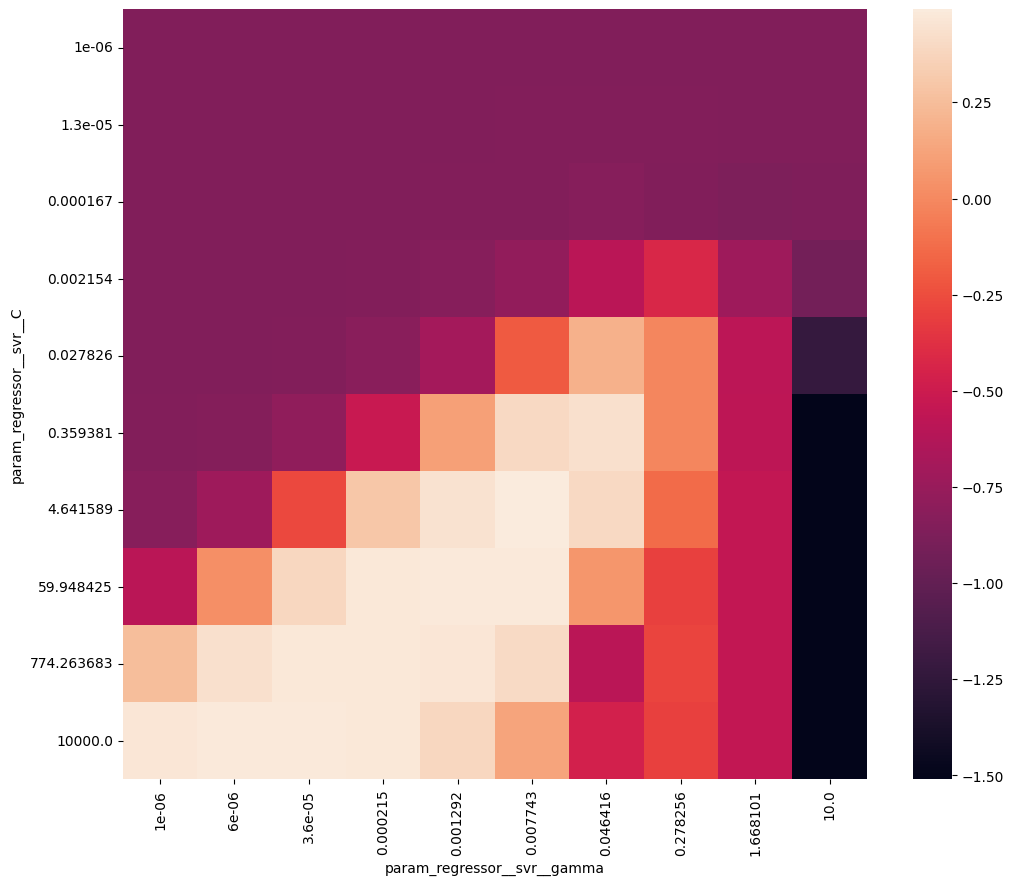

In [85]:
grid1 = joblib.load('../models/opt_searches/grid1.pkl')
results = pd.DataFrame(grid1.cv_results_)

m = results[['mean_test_score', 'param_regressor__svr__C', 'param_regressor__svr__gamma']].pivot(index='param_regressor__svr__C', columns='param_regressor__svr__gamma', values='mean_test_score')

_, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(m, ax=ax)
ax.set_xticklabels(np.round(m.columns.to_numpy(), 6))
ax.set_yticklabels(np.round(m.index.to_numpy(), 6))

In [86]:
%%time

param_grid = {
    'regressor__svr__C':np.logspace(-1, 4, 10),
    'regressor__svr__gamma':np.logspace(-6, -2, 10)
}
grid2 = GridSearchCV(
    estimator=svr_pipe_ttr,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)
grid2.fit(X_train_val, y_train_val)
joblib.dump(grid2, '../models/opt_searches/grid2.pkl')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END .regressor__svr__C=0.1, regressor__svr__gamma=1e-06; total time=   9.2s
[CV] END regressor__svr__C=0.1, regressor__svr__gamma=2.782559402207126e-06; total time=   9.2s
[CV] END regressor__svr__C=0.1, regressor__svr__gamma=7.742636826811277e-06; total time=   9.4s
[CV] END regressor__svr__C=0.1, regressor__svr__gamma=2.1544346900318823e-05; total time=   9.3s
[CV] END .regressor__svr__C=0.1, regressor__svr__gamma=1e-06; total time=  30.0s
[CV] END regressor__svr__C=0.1, regressor__svr__gamma=7.742636826811277e-06; total time=  30.2s
[CV] END regressor__svr__C=0.1, regressor__svr__gamma=2.782559402207126e-06; total time=  30.6s
[CV] END regressor__svr__C=0.1, regressor__svr__gamma=5.994842503189409e-05; total time=   8.9s
[CV] END regressor__svr__C=0.1, regressor__svr__gamma=2.1544346900318823e-05; total time=  29.6s
[CV] END regressor__svr__C=0.1, regressor__svr__gamma=0.0001668100537200059; total time=   8.8s
[CV] 

['../models/opt_searches/grid2.pkl']

In [87]:
%%time

param_grid = {
    'regressor__svr__C':np.logspace(-6, 6, 10),
    'regressor__svr__gamma':np.logspace(-6, 1, 10)
}
gridrmse = GridSearchCV(
    estimator=svr_pipe_ttr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
gridrmse.fit(X_train_val, y_train_val)
# joblib.dump(gridrmse, '../models/opt_searches/grid1.pkl')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=5.994842503189409e-06; total time=   7.2s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=1e-06; total time=   7.4s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=3.5938136638046256e-05; total time=   7.3s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=0.00021544346900318845; total time=   9.3s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=1e-06; total time=  27.8s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=5.994842503189409e-06; total time=  28.2s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=3.5938136638046256e-05; total time=  28.2s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=0.001291549665014884; total time=   9.1s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=0.00021544346900318845; total time=  29.6s
[CV] END regressor__svr__C=1e-06, regressor__svr__gamma=0.007742636826811269; total 

KeyboardInterrupt: 

### Random Search

In [ ]:
# %%time

# param_distributions = {
#     'regressor__svr__C':stats.loguniform(1e-6, 1e+4),
#     'regressor__svr__gamma':stats.loguniform(1e-6, 1e+1)
# }
# rand = RandomizedSearchCV(
#     estimator=svr_pipe_ttr,
#     param_distributions=param_distributions,
#     n_iter=100, 
#     cv=tscv,
#     n_jobs=-1,
#     verbose=2,
#     random_state=1
# )
# rand.fit(X_train_val, y_train_val)
# svr_randomsearchcv = clone(svr_pipe_ttr)
# svr_randomsearchcv.set_params(**rand.best_params_).fit(X_train_val, y_train_val)
# joblib.dump(svr_randomsearchcv, '../models/svr_randomsearchcv.pkl')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END regressor__svr__C=0.01479858008262409, regressor__svr__gamma=0.110222803767004; total time=   4.0s
[CV] END regressor__svr__C=1.0026370484058345e-06, regressor__svr__gamma=0.0001307157768930744; total time=   9.3s
[CV] END regressor__svr__C=2.9346675384251153e-05, regressor__svr__gamma=4.429657657076254e-06; total time=   9.4s
[CV] END regressor__svr__C=0.01479858008262409, regressor__svr__gamma=0.110222803767004; total time=   9.7s
[CV] END regressor__svr__C=7.287895114844979e-05, regressor__svr__gamma=0.00026237659355350326; total time=   9.8s
[CV] END regressor__svr__C=0.01479858008262409, regressor__svr__gamma=0.110222803767004; total time=  21.4s
[CV] END regressor__svr__C=0.009282709131819137, regressor__svr__gamma=0.005911764673828903; total time=   9.1s
[CV] END regressor__svr__C=1.0026370484058345e-06, regressor__svr__gamma=0.0001307157768930744; total time=  32.7s
[CV] END regressor__svr__C=2.934667538425

['../models/svr_randomsearchcv.pkl']

### Bayesian Search

In [54]:
%%time

search_spaces = {
    'regressor__svr__C':Real(1e-6, 1e+4, prior='log-uniform'),
    'regressor__svr__gamma':Real(1e-6, 1e+1, prior='log-uniform')
}
bogp = BayesSearchCV(
    estimator=svr_pipe_ttr,
    search_spaces=search_spaces,
    optimizer_kwargs={'base_estimator':'GP'},
    n_iter=100,
    n_jobs=-1,
    n_points=4,
    cv=tscv,
    random_state=2,
    verbose=2
)
bogp.fit(X_train_val, y_train_val)
svr_bayessearchcv = clone(svr_pipe_ttr)
svr_bayessearchcv.set_params(**bogp.best_params_).fit(X_train_val, y_train_val)
joblib.dump(svr_bayessearchcv, '../models/svr_bayessearchcv.pkl')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[CV] END regressor__svr__C=68.6553081265541, regressor__svr__gamma=0.007720270241167801; total time=   1.5s
[CV] END regressor__svr__C=453.2986851812845, regressor__svr__gamma=0.00022860582273805398; total time=   1.6s
[CV] END regressor__svr__C=453.2986851812845, regressor__svr__gamma=0.00022860582273805398; total time=   3.2s
[CV] END regressor__svr__C=68.6553081265541, regressor__svr__gamma=0.007720270241167801; total time=   3.6s
[CV] END regressor__svr__C=221.86441850209155, regressor__svr__gamma=0.1201212170580727; total time=   4.7s
[CV] END regressor__svr__C=0.004629025482077633, regressor__svr__gamma=2.3314740194608337e-06; total time=   3.1s
[CV] END regressor__svr__C=453.2986851812845, regressor__svr__gamma=0.00022860582273805398; total time=   5.7s
[CV] END regressor__svr__C=68.6553081265541, regressor__svr__gamma=0.007720270241167801; total time=   6.0s
[CV] END regressor__svr__C=221.86441850209155, regressor__svr__gamma=0.1201212170580727; total time=   9.7s
[CV] END regr

['../models/svr_bayessearchcv.pkl']

In [11]:
evaluate_model(svr_gridsearchcv, X_test, y_test)

,property,metric,score
0,variance,r2,0.043451
1,variance,wi,0.713578
2,variance,ns,0.043451
3,variance,lm,-0.150887
4,variance,kge,-0.073032
5,bias,rmse,59.301665
6,bias,mae,43.391280
7,bias,nrmse,0.680566
8,bias,rmae,0.497973
9,bias,smape,0.612452


In [56]:
print(svr_randomsearchcv.get_params)
evaluate_model(svr_randomsearchcv, X_test, y_test)

<bound method BaseEstimator.get_params of TransformedTargetRegressor(regressor=Pipeline(memory=Memory(location=svr_cache/tmps16cdwha/joblib),
                                              steps=[('normalizer',
                                                      MinMaxScaler()),
                                                     ('svr',
                                                      SVR(C=np.float64(0.10723441152701033),
                                                          gamma=np.float64(0.06259454728975193)))]),
                           transformer=MinMaxScaler())>


,property,metric,score
0,variance,r2,0.347397
1,variance,wi,0.748927
2,variance,ns,0.347397
3,variance,lm,0.124769
4,variance,kge,0.240210
5,bias,rmse,48.982153
6,bias,mae,32.998370
7,bias,nrmse,0.562136
8,bias,rmae,0.378701
9,bias,smape,0.485840


In [57]:
print(svr_bayessearchcv.get_params)
evaluate_model(svr_bayessearchcv, X_test, y_test)

<bound method BaseEstimator.get_params of TransformedTargetRegressor(regressor=Pipeline(memory=Memory(location=svr_cache/tmpi0tjkc5h/joblib),
                                              steps=[('normalizer',
                                                      MinMaxScaler()),
                                                     ('svr',
                                                      SVR(C=4.64589189048959,
                                                          gamma=0.01912739073073955))]),
                           transformer=MinMaxScaler())>


,property,metric,score
0,variance,r2,0.365725
1,variance,wi,0.780682
2,variance,ns,0.365725
3,variance,lm,0.122738
4,variance,kge,0.043154
5,bias,rmse,48.289442
6,bias,mae,33.074947
7,bias,nrmse,0.554186
8,bias,rmae,0.379579
9,bias,smape,0.547078
